In [5]:
# Step 1: Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


In [6]:
# Step 2: Load data, remove Id column
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

train_data = train_data.drop(columns=['Id'])
test_data = test_data.drop(columns=['Id'])

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (1460, 80)
Test data shape: (1459, 79)


In [7]:
from project.src.utils import classify_price

# Step 3: Create price categories
train_data['PriceCategory'] = train_data['SalePrice'].apply(classify_price)

print("Price category distribution:")
print(train_data['PriceCategory'].value_counts())
print(f"\nPercentages:")
print(train_data['PriceCategory'].value_counts(normalize=True) * 100)

Price category distribution:
PriceCategory
1    494
2    483
0    483
Name: count, dtype: int64

Percentages:
PriceCategory
1    33.835616
2    33.082192
0    33.082192
Name: proportion, dtype: float64


In [8]:
# Step 4: Select Features and Target
X = train_data.drop(columns=['SalePrice', 'PriceCategory'], axis=1)
y = train_data['PriceCategory']

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {len(categorical_features)}")

Numeric features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical features: 43


In [9]:
# Step 5: Preprocess Features
from sklearn.preprocessing import LabelEncoder

# Handle numeric features - fill missing values with median
X_numeric = X[numeric_features].fillna(X[numeric_features].median())

# Handle categorical features - encode and fill missing values
X_categorical = X[categorical_features].copy()
X_categorical = X_categorical.fillna('Missing')  # Fill NaN with 'Missing'

# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_categorical[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

# Combine numeric and encoded categorical features
X_processed = pd.concat([X_numeric, X_categorical], axis=1)

print(f"\nTotal features after preprocessing: {X_processed.shape[1]}")
print(f"Total samples: {X_processed.shape[0]}")


Total features after preprocessing: 79
Total samples: 1460


In [10]:
# Step 6: Split Data (60% Train, 20% Validation, 20% Test)

# 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y, test_size=0.4, random_state=42, stratify=y
)

# 20% validation, 20% test (50-50% of remaining 40%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")


Training set size: 876 (60.0%)
Validation set size: 292 (20.0%)
Test set size: 292 (20.0%)


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [12]:
# Step 7: Train Logistic Regression Model

lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train_scaled, y_train)


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/hayden/

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [13]:
# Step 8: Evaluate on Training and validation Set
y_train_pred = lr_model.predict(X_train_scaled)
train_accuracy = metrics.accuracy_score(y_train, y_train_pred)

print(f"\n=== Training Set Performance ===")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"\nClassification Report:")
print(metrics.classification_report(y_train, y_train_pred, target_names=['Low', 'Medium', 'High']))



=== Training Set Performance ===
Accuracy: 0.8881

Classification Report:
              precision    recall  f1-score   support

         Low       0.92      0.94      0.93       290
      Medium       0.84      0.82      0.83       296
        High       0.90      0.91      0.90       290

    accuracy                           0.89       876
   macro avg       0.89      0.89      0.89       876
weighted avg       0.89      0.89      0.89       876



/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [14]:
y_val_pred = lr_model.predict(X_val_scaled)
val_accuracy = metrics.accuracy_score(y_val, y_val_pred)

print(f"\n=== Validation Set Performance ===")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"\nClassification Report:")
print(metrics.classification_report(y_val, y_val_pred, target_names=['Low', 'Medium', 'High']))



=== Validation Set Performance ===
Accuracy: 0.7877

Classification Report:
              precision    recall  f1-score   support

         Low       0.79      0.88      0.83        96
      Medium       0.74      0.63      0.68        99
        High       0.83      0.87      0.85        97

    accuracy                           0.79       292
   macro avg       0.78      0.79      0.78       292
weighted avg       0.78      0.79      0.78       292



/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [15]:
y_test_pred = lr_model.predict(X_test_scaled)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

print(f"\n=== Test Set Performance ===")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"\nClassification Report:")
print(metrics.classification_report(y_test, y_test_pred, target_names=['Low', 'Medium', 'High']))



=== Test Set Performance ===
Accuracy: 0.8356

Classification Report:
              precision    recall  f1-score   support

         Low       0.88      0.88      0.88        97
      Medium       0.78      0.74      0.76        99
        High       0.85      0.90      0.87        96

    accuracy                           0.84       292
   macro avg       0.83      0.84      0.84       292
weighted avg       0.83      0.84      0.83       292



/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


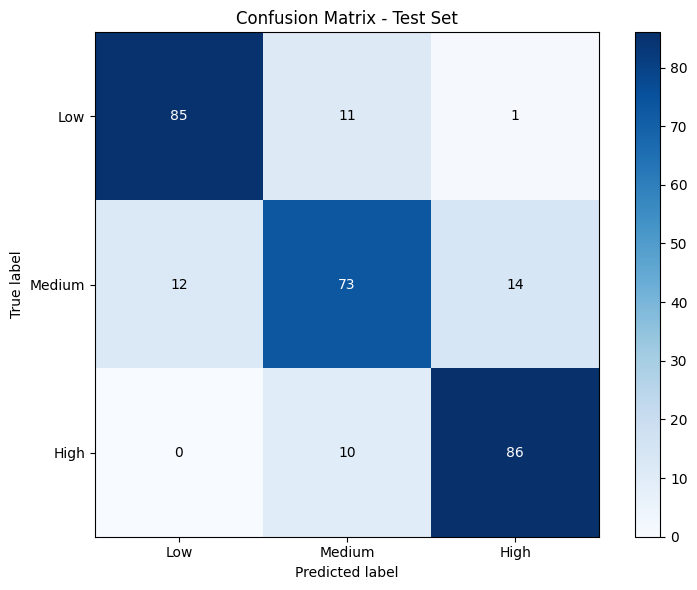

In [16]:
# Step 9: Confusion Matrix for Test Set

conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Low', 'Medium', 'High'])
plt.yticks(tick_marks, ['Low', 'Medium', 'High'])

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [17]:
# Step 10: Summary
print("\n=== Model Summary ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nNumber of features used: {len(numeric_features)}")
print(f"Model type: Logistic Regression (multinomial)")



=== Model Summary ===
Training Accuracy: 0.8881
Validation Accuracy: 0.7877
Test Accuracy: 0.8356

Number of features used: 36
Model type: Logistic Regression (multinomial)
